# 1. Datenaufbereitung

Importieren der notwendigen Packages

In [10]:
import matplotlib.pyplot as plt
%matplotlib inline
import seaborn as sns
sns.set(rc={'figure.figsize':(11.7,8.27)})
import numpy as np
import pandas as pd
from sklearn.preprocessing import StandardScaler
from sklearn.model_selection import train_test_split

Parameter zum Einlesen und Speichern des XGBoost Modells

In [11]:
FROM_SCRATCH = True

Einlesen der Daten

In [12]:
store = pd.read_csv('input/store.csv')
train = pd.read_csv('input/train.csv',parse_dates=[2])
test = pd.read_csv('input/test.csv',parse_dates=[3])
# fillna in store with 0 has better result than median()
# Aufbereiten der daten
store.fillna(0, inplace=True)
# fill missing values in test with 1
# Aufbereiten der Daten
test.fillna(value = 1, inplace = True)
# merge data with store
# Alles in eine Tabelle
train = pd.merge(train, store, on='Store')
test = pd.merge(test, store, on='Store')
# only use data of Sales>0 and Open is 1
train = train[(train.Open != 0)&(train.Sales >0)]

C:\Users\timgr\AppData\Local\Temp\ipykernel_13884\341166967.py:2: DtypeWarning: Columns (7) have mixed types. Specify dtype option on import or set low_memory=False.
  train = pd.read_csv('input/train.csv',parse_dates=[2])


Plotte Verkaufszahlen von Store 1 und 10 über den gesamten Zeitraum

Text(0.5, 1.0, 'Store 10 Sales Distribution')

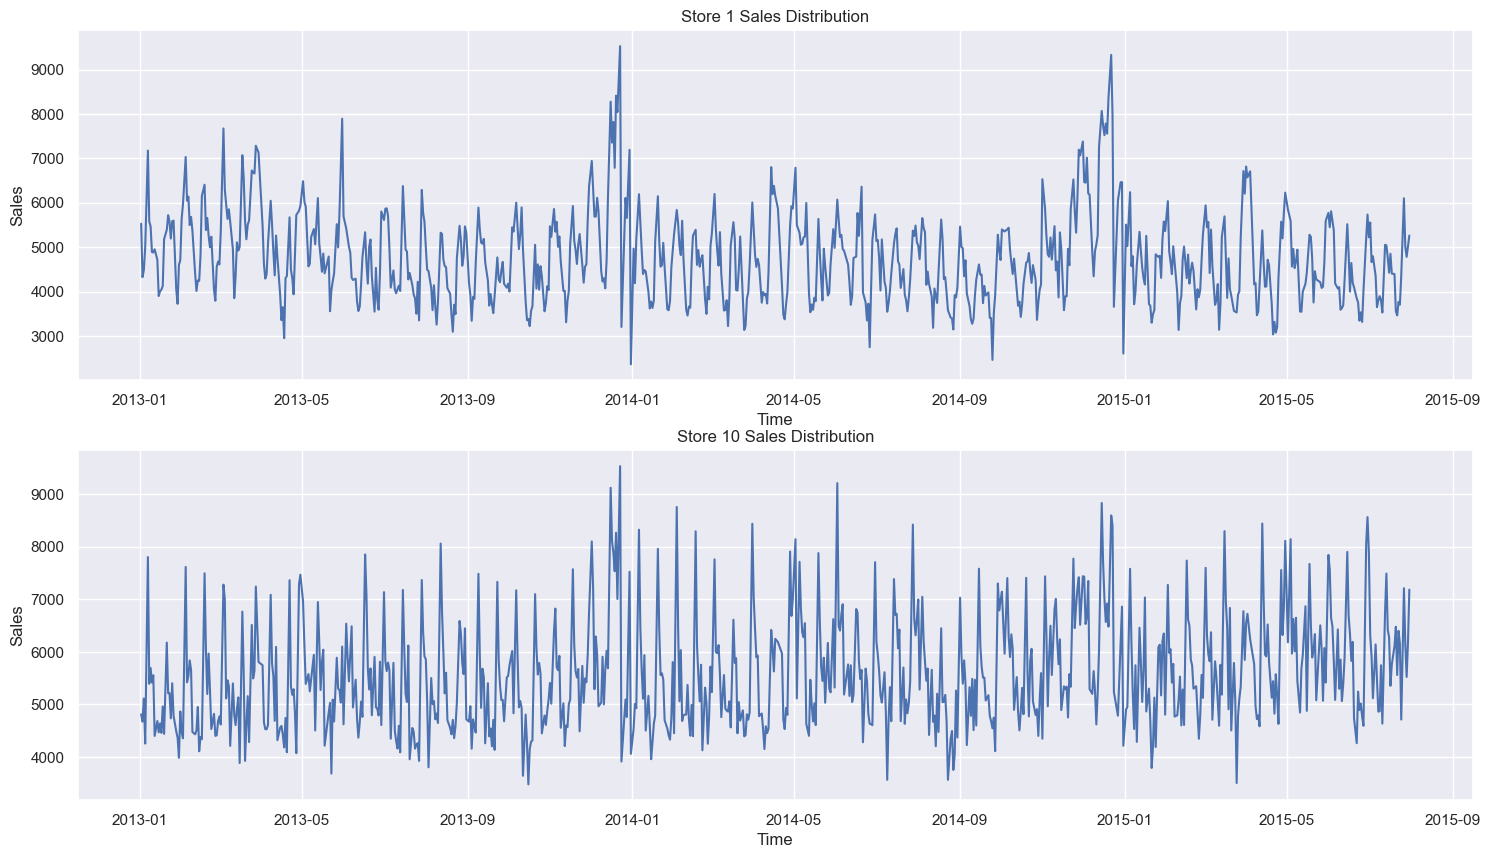

In [13]:
import matplotlib.pyplot as plt
store_1 = train.loc[(train["Store"]==1)&(train['Sales']>0), ['Date',"Sales"]]
store_10 = train.loc[(train["Store"]==10)&(train['Sales']>0), ['Date',"Sales"]]
f = plt.figure(figsize=(18,10))
ax1 = f.add_subplot(211)
ax1.plot(store_1['Date'], store_1['Sales'], '-')
ax1.set_xlabel('Time')
ax1.set_ylabel('Sales')
ax1.set_title('Store 1 Sales Distribution')

ax2 = f.add_subplot(212)
ax2.plot(store_10['Date'], store_10['Sales'], '-')
ax2.set_xlabel('Time')
ax2.set_ylabel('Sales')
ax2.set_title('Store 10 Sales Distribution')

Plotte Verteilung der offenen Tage der Stores

Text(0.5, 1.0, 'Store Daily Open Countplot')

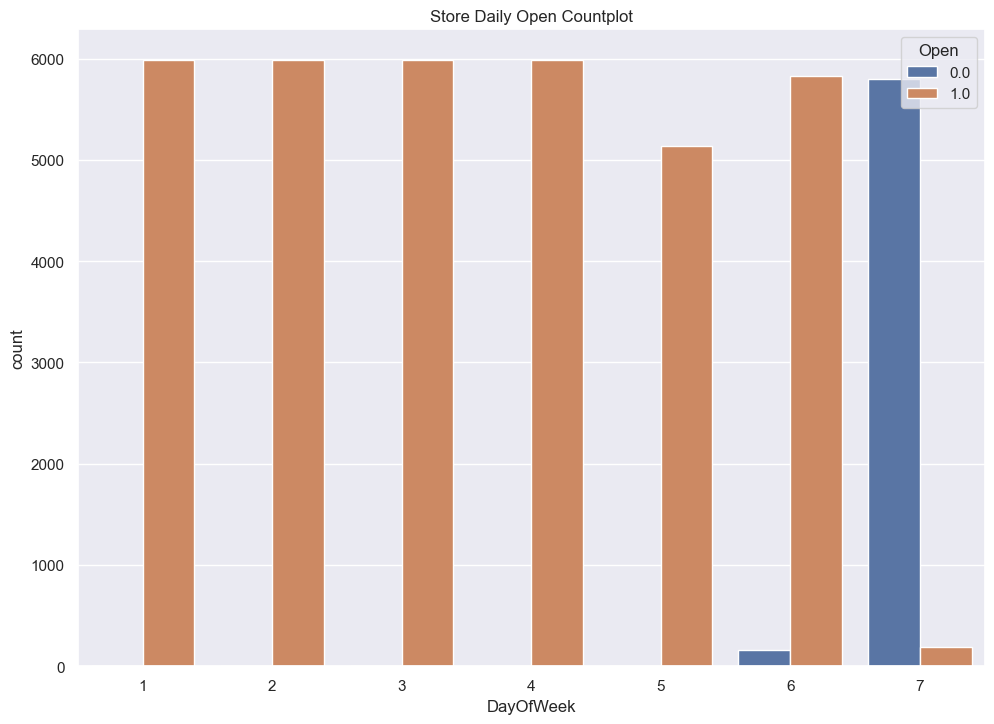

In [14]:
import seaborn as sns
sns.countplot(x = 'DayOfWeek', hue = 'Open', data = test)
plt.title('Store Daily Open Countplot')

Dichteverteilung der Verkaufszahlen.
Einmal normal und einmal logarithmisch + normalisiert

C:\Users\timgr\anaconda3\lib\site-packages\seaborn\distributions.py:2619: FutureWarning: `distplot` is a deprecated function and will be removed in a future version. Please adapt your code to use either `displot` (a figure-level function with similar flexibility) or `histplot` (an axes-level function for histograms).
  warnings.warn(msg, FutureWarning)
C:\Users\timgr\anaconda3\lib\site-packages\seaborn\distributions.py:2619: FutureWarning: `distplot` is a deprecated function and will be removed in a future version. Please adapt your code to use either `displot` (a figure-level function with similar flexibility) or `histplot` (an axes-level function for histograms).
  warnings.warn(msg, FutureWarning)


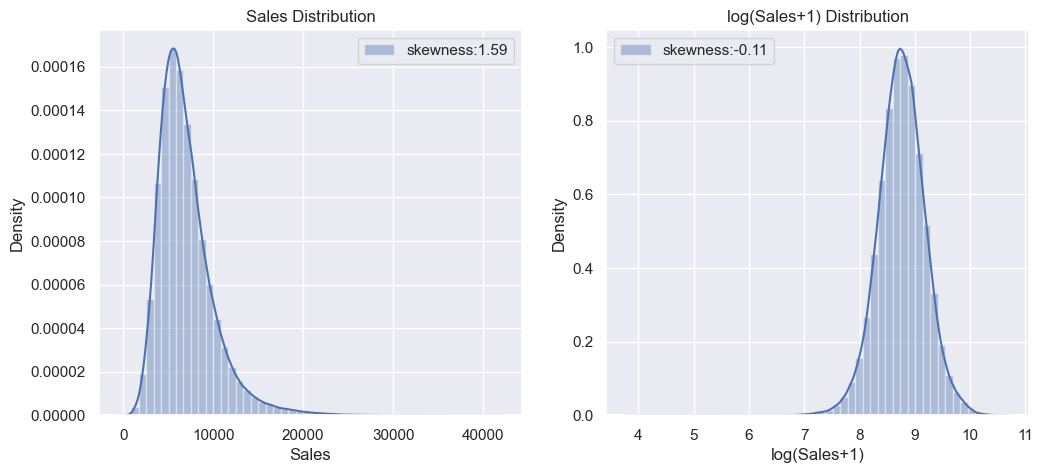

In [15]:
import seaborn as sns
import matplotlib.pyplot as plt

# plotten der Verteilung der Verkäufe aller Stores der Trainingsdaten
fig = plt.figure(figsize=(12,5))
ax1 = fig.add_subplot(121)
ax2 = fig.add_subplot(122)
g1 = sns.distplot(train['Sales'],hist = True,label='skewness:{:.2f}'.format(train['Sales'].skew()),ax = ax1)
g1.legend()
g1.set(xlabel = 'Sales', ylabel = 'Density', title = 'Sales Distribution')
g2 = sns.distplot(np.log1p(train['Sales']),hist = True,label='skewness:{:.2f}'.format(np.log1p(train['Sales']).skew()),ax=ax2)
g2.legend()
g2.set(xlabel = 'log(Sales+1)',ylabel = 'Density', title = 'log(Sales+1) Distribution')
plt.show()

Quantile erzeugen für die Klassifikation.
Dies braucht es später für die Anchor Methode

In [16]:
# Anzahl der Quantile
nQ = 5
# neue Spalte 'Class' hinzugefügt
train['Class'] = 0
classes = np.arange(0,nQ+1)
#  Quantile für alle Tage
quantile = np.arange(1, nQ) / nQ
store_quan = np.arange(0, nQ+2)
store_quan[0] = -1
store_quan[1] = 1
# Quantile berechnet und max am Ende des Arrays gespeichert
for index, x in enumerate(quantile):
    store_quan[index+2] = train['Sales'].quantile(x)
store_quan[nQ+1] = train['Sales'].max()

Aufbereiten der Daten.
Es werden manche Spalten aufgeteilt und ein paar werden entfernt.

In [17]:
# process train and test
def process(data, isTest = False):
    # label encode some features
    mappings = {'0':0, 'a':1, 'b':2, 'c':3, 'd':4}
    # buchstaben zu zahlen
    data.StoreType.replace(mappings, inplace=True)
    data.Assortment.replace(mappings, inplace=True)
    data.StateHoliday.replace(mappings, inplace=True)

    # extract some features from date column
    data['Month'] = data.Date.dt.month
    data['Year'] = data.Date.dt.year
    data['Day'] = data.Date.dt.day
    data['WeekOfYear'] = data.Date.dt.weekofyear

    # calculate competiter open time in months
    data['CompetitionOpen'] = 12 * (data.Year - data.CompetitionOpenSinceYear) + \
        (data.Month - data.CompetitionOpenSinceMonth)
    data['CompetitionOpen'] = data['CompetitionOpen'].apply(lambda x: x if x > 0 else 0)

    # calculate promo2 open time in months
    data['PromoOpen'] = 12 * (data.Year - data.Promo2SinceYear) + \
        (data.WeekOfYear - data.Promo2SinceWeek) / 4.0
    data['PromoOpen'] = data['PromoOpen'].apply(lambda x: x if x > 0 else 0)

    # Indicate whether the month is in promo interval
    month2str = {1:'Jan', 2:'Feb', 3:'Mar', 4:'Apr', 5:'May', 6:'Jun', \
             7:'Jul', 8:'Aug', 9:'Sept', 10:'Oct', 11:'Nov', 12:'Dec'}
    data['month_str'] = data.Month.map(month2str)

    # schaut ob Monat ein Promomonat ist
    def check(row):
        if isinstance(row['PromoInterval'],str) and row['month_str'] in row['PromoInterval']:
            return 1
        else:
            return 0
    # wenn ja dann hinzugefügt
    data['IsPromoMonth'] =  data.apply(lambda row: check(row),axis=1)

    # select the features we need
    features = ['DayOfWeek', 'Promo', 'StateHoliday', 'SchoolHoliday',
       'StoreType', 'Assortment', 'CompetitionDistance',
       'CompetitionOpenSinceMonth', 'CompetitionOpenSinceYear', 'Promo2',
       'Promo2SinceWeek', 'Promo2SinceYear', 'Month', 'Day',
       'WeekOfYear', 'CompetitionOpen', 'PromoOpen', 'IsPromoMonth']

    # wenn kein Test dann hinzufügen von Sales
    if not isTest:
        features.append('Sales')

    data = data[features]
    return data

for j in range(1, 1115):
    globals()['store_%s' % j] = train.loc[(train["Store"]==j) & (train['Date'] >= '2015-06-01')]
    globals()['date_store_%s' % j] = globals()['store_%s' % j]['Date'].tolist()
    globals()['store_%s' % j] = process(globals()['store_%s' % j], isTest=False)
    globals()['sales_store_%s' % j] = globals()['store_%s' % j]['Sales']
    del globals()['store_%s' % j]['Sales']

#store_3 = train.loc[(train["Store"]==3) & (train['Date'] >= '2015-06-01')]
#date_store_3 = store_3['Date'].tolist()
#store_3 = process(store_3, isTest=False)
#sales_store_3 = store_3['Sales']
#del store_3['Sales']

#store_4 = train.loc[(train["Store"]==4) & (train['Date'] >= '2015-06-01')]
#date_store_4 = store_4['Date'].tolist()
#store_4 = process(store_4, isTest=False)
#sales_store_4 = store_4['Sales']
#del store_4['Sales']

train = train.sort_values(['Date'],ascending = False)
train = process(train)
test = process(test,isTest = True)

C:\Users\timgr\AppData\Local\Temp\ipykernel_13884\1327502399.py:6: SettingWithCopyWarning: 
A value is trying to be set on a copy of a slice from a DataFrame

See the caveats in the documentation: https://pandas.pydata.org/pandas-docs/stable/user_guide/indexing.html#returning-a-view-versus-a-copy
  data.StoreType.replace(mappings, inplace=True)
C:\Users\timgr\AppData\Local\Temp\ipykernel_13884\1327502399.py:7: SettingWithCopyWarning: 
A value is trying to be set on a copy of a slice from a DataFrame

See the caveats in the documentation: https://pandas.pydata.org/pandas-docs/stable/user_guide/indexing.html#returning-a-view-versus-a-copy
  data.Assortment.replace(mappings, inplace=True)
C:\Users\timgr\AppData\Local\Temp\ipykernel_13884\1327502399.py:8: SettingWithCopyWarning: 
A value is trying to be set on a copy of a slice from a DataFrame

See the caveats in the documentation: https://pandas.pydata.org/pandas-docs/stable/user_guide/indexing.html#returning-a-view-versus-a-copy
  data.

Daten werden zu Numpy konvertiert und in Trainings und Testdaten splitten

In [18]:
# Liste mit den Features
featuresR  = ['DayOfWeek', 'Promo', 'StateHoliday', 'SchoolHoliday',
       'StoreType', 'Assortment', 'CompetitionDistance',
       'CompetitionOpenSinceMonth', 'CompetitionOpenSinceYear', 'Promo2',
       'Promo2SinceWeek', 'Promo2SinceYear', 'Month', 'Day',
       'WeekOfYear', 'CompetitionOpen', 'PromoOpen', 'IsPromoMonth']

# Features zu Arrays
train_data = train[featuresR].to_numpy()
test_data = test[featuresR].to_numpy()
labels_train = train[['Sales']].to_numpy()
labels_train = np.log1p(labels_train)

# Daten aufteilen in Test und Trainingsdaten, skalieren der Daten und Schätzer berechnen
X_trainR, X_testR, y_trainR, y_testR = train_test_split(train_data, labels_train, random_state=0, test_size= 2/31)
X_trainR, X_testR = X_trainR.astype('float32'), X_testR.astype('float32')
y_train_labR, y_test_labR = y_trainR[:, 0], y_testR[:, 0]
y_trainR, y_testR = y_trainR[:, 1:].astype('float32'), y_testR[:, 1:].astype('float32')
scalerR = StandardScaler()
scalerR.fit(X_trainR)

StandardScaler()

# 2. Feature Selection

Definition von Evaluationsmetriken

In [19]:
# Mittleres Abweichungsquadrat
from sklearn.metrics import mean_squared_error
def rmspe(y, yhat):
    return np.sqrt(np.mean((yhat/y-1) ** 2))
# expm1 ist umkehr von log1p
def rmspe_xg(yhat, y):
    y = np.expm1(y.get_label())
    yhat = np.expm1(yhat)
    return "rmspe", rmspe(y,yhat)
def rmse(ytest, y):
    return np.sqrt(mean_squared_error(ytest, y))

In [20]:
y_train_xgb = y_train_labR
y_test_xgb = y_test_labR

Definition des ersten XGBoost Modells.
Dieses XGBoost Modell wird verwendet, um die Feature Importance und Selection anwenden zu können.
Später wird ein weiteres XGBoost Modell mit weniger Features erzeugt.

In [23]:
import xgboost as xgb
from sklearn.metrics import accuracy_score

def make_xgb_modelR():
    params = {"objective": "reg:linear", # for linear regression
              "booster" : "gbtree",   # use tree based models
              "eta": 0.03,   # learning rate
              "max_depth": 10,    # maximum depth of a tree
              "subsample": 0.9,    # Subsample ratio of the training instances
              "colsample_bytree": 0.7,   # Subsample ratio of columns when constructing each tree
              "silent": 1,   # silent mode
              "seed": 10,   # Random number seed
              "gpu_id": 0,
              # "tree_method": "gpu_hist",
              # "eval_metric": "rmse"
              }
    # anzahl trainingsrunden
    num_boost_round = 500

    dtrain = xgb.DMatrix(X_trainR, y_train_xgb)
    dtest = xgb.DMatrix(X_testR, y_test_xgb)
    watchlist = [(dtrain, 'train'), (dtest, 'eval')]
    # train the xgboost model
    model = xgb.train(params, dtrain, num_boost_round, evals=watchlist, \
      early_stopping_rounds= 10, feval=rmspe_xg, verbose_eval=True)
    y_predR = model.predict(xgb.DMatrix(X_testR))
    print(y_predR)
    print('accuracy_score:', rmse(y_predR, y_test_xgb))
    # print('f1_score:', f1_score(y_predR, y_test_xgb))

    return model

Erzeugung des Modells
Das Modell kann abgespeichert und eingelesen werden

In [24]:
import os.path

if FROM_SCRATCH or not os.path.isfile('modelXGBR.json'):
    modelXGBR = make_xgb_modelR()
    modelXGBR.save_model('modelXGBR.json')
else:
    modelXGBR = xgb.Booster()
    modelXGBR.load_model('modelXGBR.json')

[14:58:28] WARNING: c:\windows\temp\abs_557yfx631l\croots\recipe\xgboost-split_1659548953302\work\src\objective\regression_obj.cu:188: reg:linear is now deprecated in favor of reg:squarederror.
[14:58:28] WARNING: C:\Windows\Temp\abs_557yfx631l\croots\recipe\xgboost-split_1659548953302\work\src\learner.cc:576: 
Parameters: { "silent" } might not be used.

  This could be a false alarm, with some parameters getting used by language bindings but
  then being mistakenly passed down to XGBoost core, or some parameter actually being used
  but getting flagged wrongly here. Please open an issue if you find any such cases.


[0]	train-rmse:8.02109	train-rmspe:0.99981	eval-rmse:8.02198	eval-rmspe:0.99981
[1]	train-rmse:7.78096	train-rmspe:0.99971	eval-rmse:7.78191	eval-rmspe:0.99971
[2]	train-rmse:7.54800	train-rmspe:0.99959	eval-rmse:7.54898	eval-rmspe:0.99959
[3]	train-rmse:7.32207	train-rmspe:0.99944	eval-rmse:7.32304	eval-rmspe:0.99945
[4]	train-rmse:7.10301	train-rmspe:0.99927	eval-rmse:7

Berechnung der Fehler
RMSE und RMSPE (root mean square percentage error)

In [25]:
y_pred = modelXGBR.predict(xgb.DMatrix(X_testR))
error = rmse(np.expm1(y_test_xgb), np.expm1(y_pred))
print('RMSE: {:.4f}'.format(error))
error = rmspe(np.expm1(y_test_xgb), np.expm1(y_pred))
print('RMSPE: {:.4f}'.format(error))

RMSE: 1012.8250
RMSPE: 0.1482


Bestimmen der Feature Importance und Darstellung in einem Plot

<BarContainer object of 18 artists>

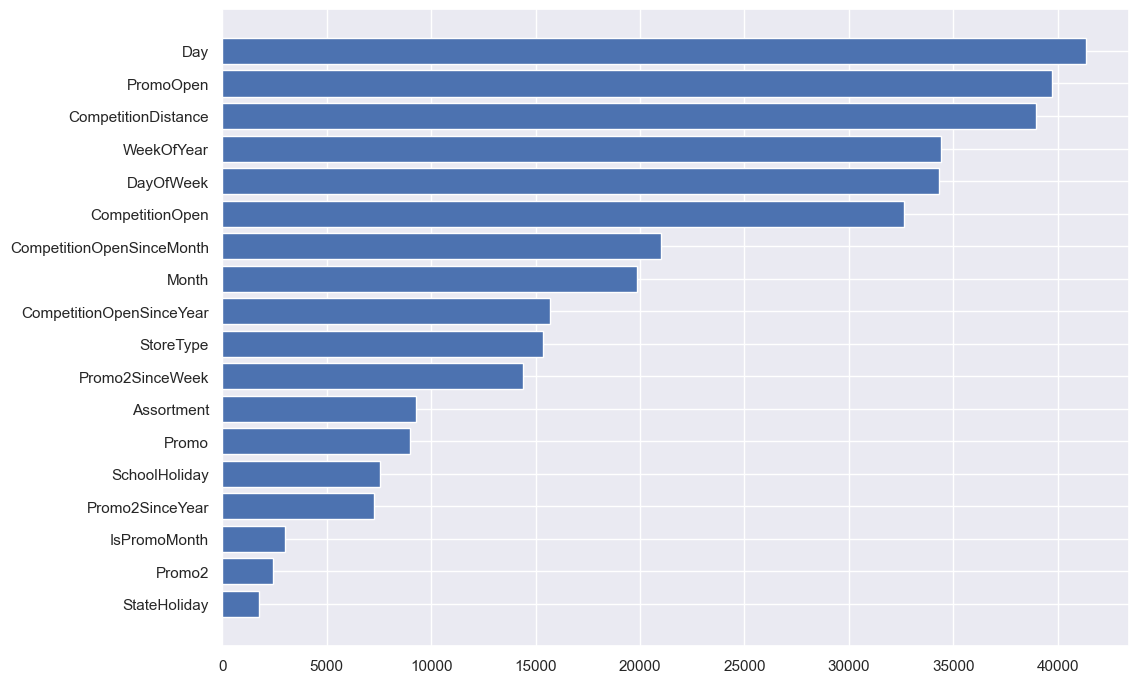

In [26]:

feature_importance = modelXGBR.get_score(importance_type= 'weight')
final_dict = dict(zip(featuresR,list(feature_importance.values())))
final_dict = dict(sorted(final_dict.items(), key=lambda x: x[1]))

plt.barh(*zip(*final_dict.items()))


Durchführung einer Sequential Feature Selection.

In [27]:
"""
#Sequential Feature Selection
from sklearn.feature_selection import SequentialFeatureSelector
from sklearn.linear_model import RidgeCV

ridge = RidgeCV(alphas=np.logspace(-6, 6, num=5)).fit(X_trainR, y_train_xgb)
importance = np.abs(ridge.coef_)
feature_names = np.array(featuresR)

#sfs_backward = SequentialFeatureSelector(ridge, n_features_to_select=10,direction ="backward").fit(X_trainR,y_train_xgb)
sfs_forward = SequentialFeatureSelector(ridge, n_features_to_select=10,direction ="forward").fit(X_trainR,y_train_xgb)
#print(
#    "Features selected by backward sequential selection: "
#    f"{feature_names[sfs_backward.get_support()]}"
#)
print(
    "Features selected by forward sequential selection: "
    f"{feature_names[sfs_forward.get_support()]}"
)
"""

'\n#Sequential Feature Selection\nfrom sklearn.feature_selection import SequentialFeatureSelector\nfrom sklearn.linear_model import RidgeCV\n\nridge = RidgeCV(alphas=np.logspace(-6, 6, num=5)).fit(X_trainR, y_train_xgb)\nimportance = np.abs(ridge.coef_)\nfeature_names = np.array(featuresR)\n\n#sfs_backward = SequentialFeatureSelector(ridge, n_features_to_select=10,direction ="backward").fit(X_trainR,y_train_xgb)\nsfs_forward = SequentialFeatureSelector(ridge, n_features_to_select=10,direction ="forward").fit(X_trainR,y_train_xgb)\n#print(\n#    "Features selected by backward sequential selection: "\n#    f"{feature_names[sfs_backward.get_support()]}"\n#)\nprint(\n    "Features selected by forward sequential selection: "\n    f"{feature_names[sfs_forward.get_support()]}"\n)\n'

Aufbereiten der Daten
Die Feature Selection wird angewendet. Es werden nur die Features verwendet, welche durch die Feature Selection ausgewählt worden sind

In [28]:
def second_process(data, isTest=False):

    # select the features we need
    features = ['DayOfWeek', 'Promo', 'Assortment', 'CompetitionDistance',
         'CompetitionOpenSinceMonth', 'CompetitionOpenSinceYear', 'Promo2SinceWeek',
         'Promo2SinceYear', 'Month', 'PromoOpen']
        #feature_names[sfs_forward.get_support()].tolist()

    # wenn kein Test dann hinzufügen von Sales
    if not isTest:
        features.append('Sales')

    data = data[features]
    return data

train = second_process(train)
test = second_process(test, isTest=True)

Daten aufsplitten in Trainings und Testdaten

In [30]:
#features = feature_names[sfs_forward.get_support()].tolist()
features = ['DayOfWeek', 'Promo', 'Assortment', 'CompetitionDistance',
 'CompetitionOpenSinceMonth', 'CompetitionOpenSinceYear', 'Promo2SinceWeek',
 'Promo2SinceYear', 'Month', 'PromoOpen']
# Features zu Arrays
train_data = train[features].to_numpy()
test_data = test.to_numpy()
#store_3 = store_3[features].to_numpy()
#store_4 = store_4[features].to_numpy()
#sales_store_3 = sales_store_3.to_numpy()
#sales_store_4 = sales_store_4.to_numpy()
labels_train = train[['Sales']].to_numpy()
labels_train = np.log1p(labels_train)

for j in range(1,1115):
    globals()['store_%s' % j] = second_process(globals()['store_%s' % j], isTest=True)
    globals()['store_%s' % j] = globals()['store_%s' % j][features].to_numpy()
    globals()['sales_store_%s' % j] = globals()['sales_store_%s' % j].to_numpy()
    globals()['store_%s' % j] = globals()['store_%s' % j].astype('float32')

# Daten aufteilen in Test und Trainingsdaten, skalieren der Daten und Schätzer berechnen
X_train, X_test, y_train, y_test = train_test_split(train_data, labels_train, random_state=0)
X_train, X_test = X_train.astype('float32'), X_test.astype('float32')
y_train_xgb, y_test_xgb = y_train[:, 0], y_test[:, 0]
y_train, y_test = y_train[:, 1:].astype('float32'), y_test[:, 1:].astype('float32')
scaler = StandardScaler()
scaler.fit(X_train)

StandardScaler()

# 3. XGBoost Modell

Zweite Definition des XGBoost Modells
Dieses Modell ist das endgültige

In [32]:
import xgboost as xgb
from sklearn.metrics import accuracy_score

def make_xgb_model():
    params = {"objective": "reg:linear",  # for linear regression
              "booster": "gbtree",  # use tree based models
              "eta": 0.03,  # learning rate
              "max_depth": 10,  # maximum depth of a tree
              "subsample": 0.9,  # Subsample ratio of the training instances
              "colsample_bytree": 0.7,  # Subsample ratio of columns when constructing each tree
              "silent": 1,  # silent mode
              "seed": 10,  # Random number seed
              "gpu_id": 0,
              #"tree_method": "gpu_hist",
              # "eval_metric": "rmse"
              }
    # anzahl trainingsrunden
    num_boost_round = 3000

    dtrain = xgb.DMatrix(X_train, y_train_xgb)
    dtest = xgb.DMatrix(X_test, y_test_xgb)
    watchlist = [(dtrain, 'train'), (dtest, 'eval')]
    # train the xgboost model
    model = xgb.train(params, dtrain, num_boost_round, evals=watchlist,
                      early_stopping_rounds=10, feval=rmspe_xg, verbose_eval=True)
    y_pred = model.predict(xgb.DMatrix(X_test))
    print(y_pred)
    print('accuracy_score:', rmse(y_pred, y_test_xgb))
    # print('f1_score:', f1_score(y_predR, y_test_xgb))

    return model

# Modell wird entweder erzeugt oder aus dem Speicher geladen
import os.path

if FROM_SCRATCH or not os.path.isfile('modelXGBR.json'):
    modelXGB = make_xgb_model()
    modelXGB.save_model('modelXGB.json')
else:
    modelXGB = xgb.Booster()
    modelXGB.load_model('modelXGB.json')

[15:06:15] WARNING: c:\windows\temp\abs_557yfx631l\croots\recipe\xgboost-split_1659548953302\work\src\objective\regression_obj.cu:188: reg:linear is now deprecated in favor of reg:squarederror.
[15:06:15] WARNING: C:\Windows\Temp\abs_557yfx631l\croots\recipe\xgboost-split_1659548953302\work\src\learner.cc:576: 
Parameters: { "silent" } might not be used.

  This could be a false alarm, with some parameters getting used by language bindings but
  then being mistakenly passed down to XGBoost core, or some parameter actually being used
  but getting flagged wrongly here. Please open an issue if you find any such cases.


[0]	train-rmse:8.02070	train-rmspe:0.99981	eval-rmse:8.02253	eval-rmspe:0.99981
[1]	train-rmse:7.78063	train-rmspe:0.99971	eval-rmse:7.78246	eval-rmspe:0.99971
[2]	train-rmse:7.54777	train-rmspe:0.99959	eval-rmse:7.54959	eval-rmspe:0.99959
[3]	train-rmse:7.32183	train-rmspe:0.99944	eval-rmse:7.32365	eval-rmspe:0.99944
[4]	train-rmse:7.10270	train-rmspe:0.99927	eval-rmse:7

Berechnung der Fehler
RMSE und RMSPE (root mean square percentage error)

In [33]:
# Berechnen von RMSE und RMSPE (root mean square percentage error)
y_pred = modelXGB.predict(xgb.DMatrix(X_test))
error = rmse(np.expm1(y_test_xgb), np.expm1(y_pred))
print('RMSE: {:.4f}'.format(error))
error = rmspe(np.expm1(y_test_xgb), np.expm1(y_pred))
print('RMSPE: {:.4f}'.format(error))

RMSE: 827.8292
RMSPE: 0.1472


Festlegen der Category Map
Dadurch wird beispielsweise statt Day = 1, Day = Monday in der Erklärung angezeigt

In [34]:
category_map = { 0: ["Monday", "Tuesday", "Wednesday", "Thursday", "Friday", "Saturday", "Sunday"], 1:["No", "Yes"],
                 2: [ "?", "Basic", "Extra", "Extended"], 8:["None","Jan", "Feb", "Mar", "Apr", "May", "Jun", "Jul", "Aug", "Sep", "Oct", "Nov", "Dec"]}

# 4. Klassifikation

Kontinuierliche Daten müssen in Klassen eingeteilt werden

In [35]:
def bin(input_array):
    output_array = np.zeros(input_array.shape)
    for i in range(len(input_array)):
        output_array[i] = np.searchsorted(store_quan, input_array[i])
    return output_array

# 5. Anchors

Definition der Anchor Methode

In [36]:
from alibi.explainers import AnchorTabular
predict_xgb = lambda x: bin(np.expm1(modelXGB.predict(xgb.DMatrix(x))))
explainerXGB = AnchorTabular(predict_xgb, features, categorical_names= category_map)
explainerXGB.fit(X_train, disc_perc=(14, 28, 42, 56, 70, 84))

AnchorTabular(meta={
  'name': 'AnchorTabular',
  'type': ['blackbox'],
  'explanations': ['local'],
  'params': {'seed': None, 'disc_perc': (14, 28, 42, 56, 70, 84)},
  'version': '0.9.0'}
)

Anchor eines beliebigen Datenpunkts

In [37]:
idx = 11
print(explainerXGB.predictor(X_test[idx].reshape(1, -1))[0])
explanation = explainerXGB.explain(X_test[idx], threshold=0.8)
print('Anchor: %s' % (' AND '.join(explanation.anchor)))
print('Precision: %.2f' % explanation.precision)
print('Coverage: %.2f' % explanation.coverage)

4.0


Could not find an anchor satisfying the 0.8 precision constraint. Now returning the best non-eligible result. The desired precision threshold might not be achieved due to the quantile-based discretisation of the numerical features. The resolution of the bins may be too large to find an anchor of required precision. Consider increasing the number of bins in `disc_perc`, but note that for some numerical distribution (e.g. skewed distribution) it may not help.


Anchor: 1700.00 < CompetitionDistance <= 5290.00 AND Promo = Yes AND 10.50 < PromoOpen <= 29.00 AND 2011.00 < Promo2SinceYear <= 2013.00 AND CompetitionOpenSinceYear <= 0.00 AND 0.00 < Promo2SinceWeek <= 14.00 AND CompetitionOpenSinceMonth <= 0.00 AND DayOfWeek = Tuesday AND Assortment = Extended AND Month = Apr
Precision: 0.70
Coverage: 0.00


In [38]:
#Erklärungen und andere Daten in Listen speichern und dann in .csv ausgeben

import pandas as pd

for j in range(1,1115):
    print('Store: ', j)
    exps = []
    anchors = []
    precisions = []
    bins = []
    predsales_store = np.expm1(modelXGB.predict(xgb.DMatrix(globals()['store_%s' % j])))
    predsales_store_list = []
    sales_store_list = []
    date_store_list = []
    for i in range(0,len(globals()['store_%s' % j])):
        print('Erklärung: ' ,i)
        exps.append(explainerXGB.explain(globals()['store_%s' % j][i], threshold=0.75, beam_size=2))
        anchors.append(exps[i].anchor)
        precisions.append(exps[i].precision)
        bins.append(explainerXGB.predictor(globals()['store_%s' % j][i].reshape(1, -1))[0])
        predsales_store_list.append(predsales_store[i])
        sales_store_list.append(globals()['sales_store_%s' % j][i])
        date_store_list.append(globals()['date_store_%s' % j][i])
    dict = {'Anchors': anchors, 'Precisions': precisions, 'Classes': bins, 'Predicted Sales': predsales_store_list, 'Dates': date_store_list, 'ESales': sales_store_list}
    df = pd.DataFrame(dict)
    df.to_csv('explanations\explanations_Store%s.csv' % j)


Store:  1
Erklärung:  0


Could not find an anchor satisfying the 0.75 precision constraint. Now returning the best non-eligible result. The desired precision threshold might not be achieved due to the quantile-based discretisation of the numerical features. The resolution of the bins may be too large to find an anchor of required precision. Consider increasing the number of bins in `disc_perc`, but note that for some numerical distribution (e.g. skewed distribution) it may not help.


Erklärung:  1


Could not find an anchor satisfying the 0.75 precision constraint. Now returning the best non-eligible result. The desired precision threshold might not be achieved due to the quantile-based discretisation of the numerical features. The resolution of the bins may be too large to find an anchor of required precision. Consider increasing the number of bins in `disc_perc`, but note that for some numerical distribution (e.g. skewed distribution) it may not help.


Erklärung:  2


Could not find an anchor satisfying the 0.75 precision constraint. Now returning the best non-eligible result. The desired precision threshold might not be achieved due to the quantile-based discretisation of the numerical features. The resolution of the bins may be too large to find an anchor of required precision. Consider increasing the number of bins in `disc_perc`, but note that for some numerical distribution (e.g. skewed distribution) it may not help.


Erklärung:  3


Could not find an anchor satisfying the 0.75 precision constraint. Now returning the best non-eligible result. The desired precision threshold might not be achieved due to the quantile-based discretisation of the numerical features. The resolution of the bins may be too large to find an anchor of required precision. Consider increasing the number of bins in `disc_perc`, but note that for some numerical distribution (e.g. skewed distribution) it may not help.


Erklärung:  4


Could not find an anchor satisfying the 0.75 precision constraint. Now returning the best non-eligible result. The desired precision threshold might not be achieved due to the quantile-based discretisation of the numerical features. The resolution of the bins may be too large to find an anchor of required precision. Consider increasing the number of bins in `disc_perc`, but note that for some numerical distribution (e.g. skewed distribution) it may not help.


Erklärung:  5
Erklärung:  6


KeyboardInterrupt: 